In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Utilities

In [2]:
def plot_toy_models(t, m):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4.8))
    axes = axes.ravel()

    axes[1].sharey(axes[0])
    axes[2].sharex(axes[0])

    c = "black"
    #for model in models[:2]:
    axes[0].plot(t, m[0], alpha=0.7, color=c)
    axes[0].plot(t, m[1], alpha=0.7, color=c, label="Gaussians Aligned")
    axes[0].plot(t, m[2], linestyle="--", label="Offset", alpha=0.7, color=c)
    
    for model in m[3:5]:
        axes[1].plot(t, model, alpha=0.7, color=c)
    axes[1].plot(t, m[5], label="Exp", alpha=0.7, color=c)
    
    for model in m[6:-1]:
        axes[2].plot(t, model, alpha=0.7, color=c)
    axes[2].plot(t, m[6], alpha=0.7, color=c)
    axes[2].plot(t, m[7], alpha=0.7, color=c, label="Cosines Aligned",)
    axes[2].plot(t, m[8], linestyle="--", label="Offset", alpha=0.7, color=c)
    
    axes[2].set_xlabel("Time")
    axes[0].set_ylabel("Value")
    axes[1].set_ylabel("Value")
    axes[2].set_ylabel("Value")
    #axes[0].set_title("Toy examples of light curves")
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()

    plt.tight_layout()

def minmax_norm(data):
    mins = np.min(data, axis=1)
    maxs = np.max(data, axis=1)
    return (data - mins[None, :].T)/(maxs - mins)[None, :].T

def meanstd_norm(data):
    avg = np.mean(data, axis=1)
    std = np.std(data, axis=1)
    return (data - avg[None, :].T)/std[None, :].T

def normalize_zip(data, time, fnorm=None):
    if fnorm is None:
        normalized = data
    else:
        normalized = fnorm(data)
    
    ncurves, nsamples = np.shape(data)
    times = np.tile(time, (ncurves, 1))
    
    ntdata = []
    for t in zip(times, normalized):
        ntdata.append(np.transpose(t))
    
    return np.array(ntdata)

# Toy Models

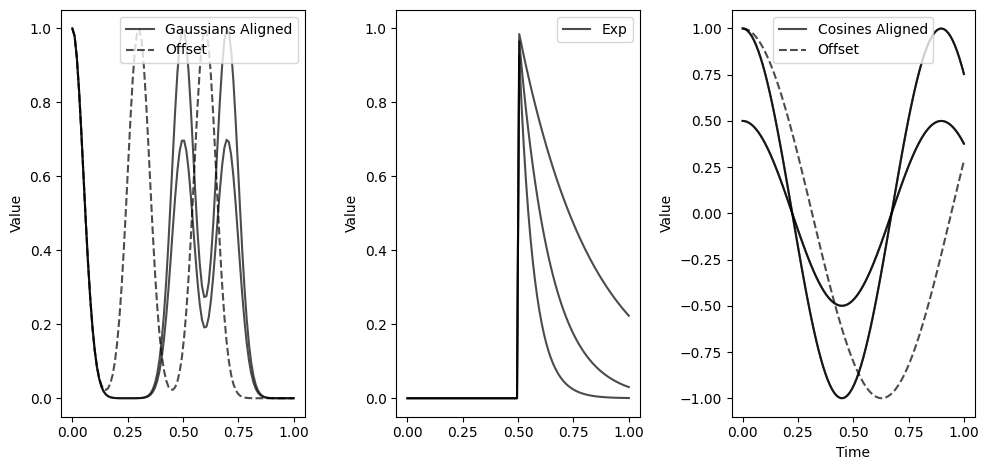

In [3]:
def normal(x, x0, sigma):
    """Returns normal, Gaussian, distribution with given parameters sampled 
    at the given positions.
    
    Parameters
    ----------
    x : `np.array`
        Sample locations
    x0 : `float` or `np.array`
        Mean, location, of the Gaussian(s)
    sigma : `float` or `np.array`
        Standard deviations, widths, of the Gaussian(s)
        
    Returns
    -------
    gaussians : `np.array`
        Sample of the given Gaussian distributions.
    """
    return (1. / np.sqrt(2 * np.pi) / sigma
            * np.exp(-0.5 * (x - x0) ** 2 / sigma ** 2))
    
def gaus_model(x, weights, locations, widths, returnGaussians=False):
    weights = np.array(weights)
    locations = np.array(locations)
    widths = np.array(widths)
    #if normalized:
    #    weights /= weights.sum()
    gaussians = weights * normal(x[:, None], locations, widths)
    if returnGaussians:
        return gaussians
    else:
        return gaussians.sum(axis=1)/gaussians.max()


def exp_model(x, x0, a):
    mask = x > x0
    y = np.zeros(x.shape)
    y[mask] = np.exp(-a*(x[mask] - x0))
    return y


def cos_model(x, amp, T, phi):
    return amp*np.cos(T*x + phi)


_times = np.linspace(0, 1, 100)

_model_lookup = {
    "gauss": 0,
    "exp": 1,
    "cos": 2
}


_models = []
_num_labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
_txt_labels = ["G1", "G2", "G3", "E1", "E2", "E3", "C1", "C2", "C3"]
_params = [
    # for gauss: weights, locations, widths
    [gaus_model, [[1, 1, 1],     [0, 0.5, 0.7], [0.05, 0.05, 0.05]]],
    [gaus_model, [[1, 0.7, 0.7], [0, 0.5, 0.7], [0.05, 0.05, 0.05]]],
    [gaus_model, [[1, 1, 1],     [0, 0.3, 0.6], [0.05, 0.05, 0.05]]],
    # for exp: x0, a 
    [exp_model, [0.5, 3]],
    [exp_model, [0.5, 7]],
    [exp_model, [0.5, 15]],
    # for cos: amp, T, phi
    [cos_model, [1,   7, 0]],
    [cos_model, [0.5, 7, 0]],
    [cos_model, [1,   5, 0]],
]


for m, p in _params:
    _models.append(m(_times, *p))


plot_toy_models(_times, _models)

# SNANA Sims

In [9]:
def plot_lcs(data, labels, axes=None):
    unique = np.unique(labels)
    if axes is None:
        fig, axes = plt.subplots(len(unique), 1, 
                                 figsize=(8, 15), sharex=True)

    if len(unique) != len(axes):
        del fig, axes
        raise ValueError("The number of provided axes does "
                         "not match the number of unique models in the data.")

    # set up a map of axis per model   
    # set up color per model
    axModelMap = {m:a for m, a in zip(unique, axes)}
    ncolors = plt.cm.viridis(np.linspace(0, 1, len(unique)))
    colorModelMap = {m:nc for m, nc in zip(unique, ncolors)} 

    for d, l in zip(data, labels):
        ax = axModelMap[l]
        ax.plot(d[:, 0], d[:, 1], alpha=0.7, color=colorModelMap[l])
        ax.set_title(l)
    
    for ax in axes:
        ax.set_ylabel("I")

    plt.tight_layout()
    
    return axes

def load_classes(n_curves, keepmodels=(["SNIa-SALT2", 'Cepheid', "AGN"])):
    models = np.load("/Users/pablocornejo/Documents/Tesis/snana_processing/data/sim_samples.npz")
    keepNlcs = n_curves

    data, labels = [], []
    for name, lcs in models.items():
        if name in keepmodels:
            for lc in lcs[:keepNlcs]:
                labels.append(name)
                data.append(lc["FLUXCAL"])

    times = models[keepmodels[0]]["MJD"][0]
    return data, times, labels

In [6]:
_models = np.load("/Users/pablocornejo/Documents/Tesis/snana_processing/data/sim_samples.npz")

print("Model Name".ljust(25) +" | N Lightcurves     ")
print("-"*45)
for k, v in _models.items():
    print(f"{k:<25} | {len(v)}")


Model Name                | N Lightcurves     
---------------------------------------------
CART                      | 1000
SNIIn+HostXT_V19          | 1000
dwarf-nova                | 300
AGN                       | 145
SNII-Templates            | 1000
uLens-Binary              | 378
SNIa-SALT2                | 1000
SNIax                     | 5
d-Sct                     | 462
KN_K17                    | 1000
Mdwarf-flare              | 304
RRL                       | 6
PISN-STELLA_HECORE        | 10
uLens-Single_PyLIMA       | 291
uLens-Single-GenLens      | 349
SNIIb+HostXT_V19          | 1000
SNIb-Templates            | 1000
SNIc-Templates            | 1000
TDE                       | 1000
PISN-STELLA_HYDROGENIC    | 1000
SNIc+HostXT_V19           | 1000
EB                        | 81
SNIa-91bg                 | 1000
SNIcBL+HostXT_V19         | 1000
Cepheid                   | 44
SNIIn-MOSFIT              | 132
SLSN-I+host               | 1000
SNIb+HostXT_V19           | 1000
SLS

In [10]:
# How to get first 5 measurements of a single AGN model lightcurve
#      Model  lc  measurements
_models["AGN"][1, :5]

array([(53000., b'i ', -9, b'VOID        ', 4096, -9.,  6.8645496, 0.00300622, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 22.883272),
       (53002., b'i ', -9, b'VOID        ', 4096, -9.,  9.438798 , 0.00304873, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 22.844124),
       (53004., b'i ', -9, b'VOID        ', 4096, -9., 12.614702 , 0.00310038, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 22.7979  ),
       (53006., b'i ', -9, b'VOID        ', 4096, -9., 10.198293 , 0.00306116, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 22.833015),
       (53008., b'i ', -9, b'VOID        ', 4096, -9., 10.484338 , 0.00306583, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 22.828756)],
      dtype=[('MJD', '<f8'), ('BAND', 'S2'), ('CCDNUM', '<i2'), ('FIELD', 'S12'), ('PHOTFLAG', '<i4'), ('PHOTPROB', '<f4'), ('FLUXCAL', '<f4'), ('FLUXCALERR', '<f4'), ('PSF_SIG1', '<f4'), ('PSF_SIG2', '<f4'), ('PSF_RATIO', '<f4'), ('SKY_SIG', '<f4'), ('SKY_SIG_T',

ValueError: too many values to unpack (expected 2)

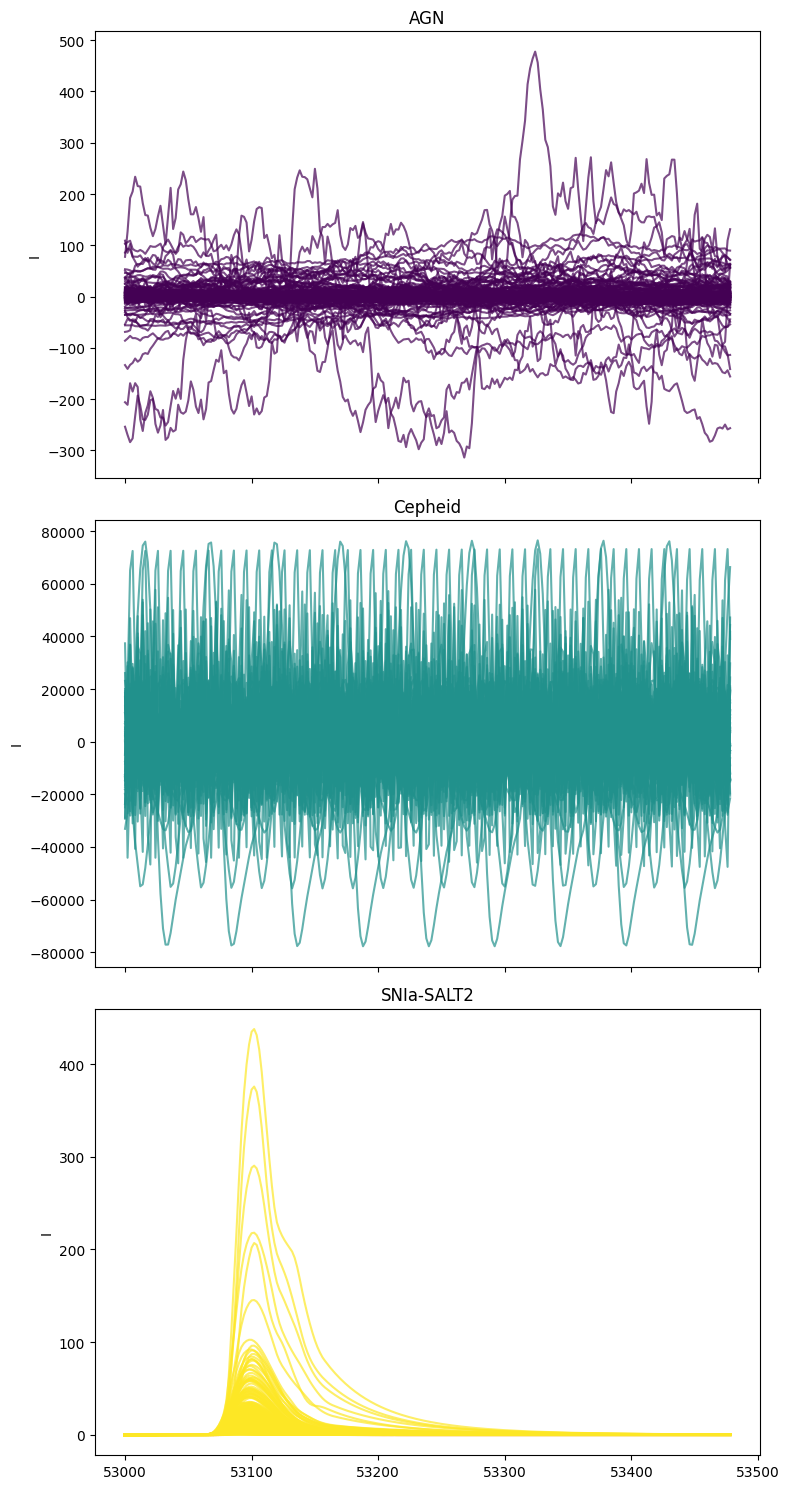

In [13]:
_fluxes, _times, _labels = load_classes(250, ["SNIa-SALT2", "Cepheid", "AGN"])
_lightcurves = normalize_zip(_fluxes, _times, fnorm=None)
fig, axes = plot_lcs(_lightcurves, _labels)

# Astropy, if you have it, may be easier to interpret

In [23]:
from astropy.table import Table
Table(_models["SNIa-SALT2"][0])

MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,XPIX,YPIX,SIM_FLUXCAL_HOSTERR,SIM_MAGOBS
float64,bytes2,int16,bytes12,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
53000.0,i,-9,VOID,0,-9.0,-0.0021240697,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53002.0,i,-9,VOID,0,-9.0,-0.0020307875,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53004.0,i,-9,VOID,0,-9.0,-0.00057658437,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53006.0,i,-9,VOID,0,-9.0,-0.0016146391,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53008.0,i,-9,VOID,0,-9.0,-0.0017621182,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53010.0,i,-9,VOID,0,-9.0,-0.00056702126,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53012.0,i,-9,VOID,0,-9.0,-0.0010773606,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53014.0,i,-9,VOID,0,-9.0,-0.0006434013,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0
53016.0,i,-9,VOID,0,-9.0,-0.0006366679,0.0014184061,1.0,0.0,0.0,4000.0,0.0,100.0,45.0,0.0,1.0,-9.0,-9.0,0.0,99.0


In [22]:
_models["SNIa-SALT2"][1]

array([(53000., b'i ', -9, b'VOID        ',    0, -9.,  2.35331413e-06, 0.00141841, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53002., b'i ', -9, b'VOID        ',    0, -9., -9.62739461e-04, 0.00141841, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53004., b'i ', -9, b'VOID        ',    0, -9.,  8.06385477e-04, 0.00141843, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53006., b'i ', -9, b'VOID        ',    0, -9., -1.15083682e-03, 0.00141841, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53008., b'i ', -9, b'VOID        ',    0, -9.,  1.42911705e-03, 0.00141846, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53010., b'i ', -9, b'VOID        ',    0, -9.,  1.31188508e-03, 0.00141845, 1., 0., 0., 4000., 0., 100., 45., 0., 1., -9., -9., 0., 99.      ),
       (53012., b'i ', -9, b'VOID        ',    0, -9., -1.83773320e-03, 0.00141841, 1., 